In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from plotnine import (
    ggplot, aes, geom_line, geom_point, facet_grid, stat_summary,
    theme, element_text, theme_bw, geom_boxplot, geom_bar, ylim,
    geom_tile, geom_text, geom_vline, coord_cartesian, coord_trans,
    geom_hline
)
from plotnine.scales import scale_y_log10, scale_x_log10, scale_x_discrete, scale_y_reverse, scale_fill_cmap, scale_y_continuous
import os

In [3]:
import torch
import numpy as np
from tqdm import tqdm
import math
import json

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
datas = []
for layers in [1, 2, 3, 4, 8, 12, 16]:
    data = pd.read_csv(f"logs/{layers}-1,1,1,1,1-1,0,0,0,0/in_context_probs.csv")
    # data['shots'] = data['shots'] + 1
    data['layers'] = layers
    datas.append(data)
data = pd.concat(datas)

filter = (data['sft_amount'] == -1)
for sft_amount in data['sft_amount'].unique():
    maxi = data[data['sft_amount'] == sft_amount]['sft'].max()
    filter |= ((data['sft'] == maxi) & (data['sft_amount'] == sft_amount)) 
data = data[filter]

In [5]:
from copy import deepcopy

sft_data = deepcopy(data)
sft_data["tokens"] = sft_data["shots"] * (sft_data["k"] + 1)
# sft_data['k'] = sft_data['k'].astype(str)

In [6]:
sft_df = pd.DataFrame(sft_data)
sft_df = sft_df.groupby(["shots", "k", "hmm", "sft", "sft_amount", "layers", "tokens"]).mean().reset_index()
sft_df["nll_avg"] = sft_df["nll"]
sft_df["nll"] = sft_df["prob"].map(lambda x: -math.log(x))
print(sft_df["sft_amount"].unique())
sft_df

[   0   50  250  500 1000 2500 5000]


,shots,k,hmm,sft,sft_amount,layers,tokens,Unnamed: 0,prob,acc,nll,nll_avg
0,0,3,0,0,0,1,0,0.0,0.241505,0.467593,1.420865,1.687721
1,0,3,0,0,0,2,0,0.0,0.200616,0.407407,1.606362,1.852371
2,0,3,0,0,0,3,0,0.0,0.182365,0.282407,1.701747,2.035992
3,0,3,0,0,0,4,0,0.0,0.226609,0.370370,1.484531,1.772636
4,0,3,0,0,0,8,0,0.0,0.231270,0.393519,1.464169,1.730885
...,...,...,...,...,...,...,...,...,...,...,...,...
154835,255,3,4,6000,5000,3,1020,135879.0,0.076974,0.087209,2.564291,5.607124
154836,255,3,4,6000,5000,4,1020,135879.0,0.078674,0.093023,2.542449,5.662209
154837,255,3,4,6000,5000,8,1020,135879.0,0.078472,0.093023,2.545013,5.795645
154838,255,3,4,6000,5000,12,1020,135879.0,0.082940,0.104651,2.489644,5.824395


In [9]:
from analyse import compute_all_fits, BayesianLawScoringFitOld, BayesianLawScoringFit

bayesian_law_mapping = {
    # "old": BayesianLawScoringFitOld,
    "new": BayesianLawScoringFit,
}
power_law_mapping = {}

In [10]:
all_params_sft = []
all_models_sft = {}
for sft_amount in sft_df["sft_amount"].unique():
    all_models_sft[sft_amount] = {}
    for k in sft_df["k"].unique():
        if k != 10: continue
        print(sft_amount, k)
        for layers in tqdm(sft_df["layers"].unique()):
            if layers <= 2: continue
            subset = sft_df[(sft_df["sft_amount"] == sft_amount) & (sft_df["k"] == k) & (sft_df["layers"] == layers)]
            some_params, some_models = compute_all_fits(
                subset=subset, max_shots=1.0, quiet=True, patience=200, epochs=200,
                lr=5e-2, num_hmms=5, i=0, metadata={"layers": layers, "k": k, "sft_amount": sft_amount},
                mode="adam", loss_mode="mse_prob", bayesian_laws=bayesian_law_mapping,
                power_laws=power_law_mapping
            )
            all_params_sft.extend(some_params)
            for key in some_models:
                if isinstance(key, tuple):
                    all_models_sft[sft_amount][(key[0], k, layers, key[1])] = some_models[key]
                else:
                    all_models_sft[sft_amount][(key, k, layers)] = some_models[key]

0 10


100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


50 10


100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


250 10


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


500 10


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


1000 10


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


2500 10


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


5000 10


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


In [80]:
params_sft_df = pd.DataFrame(all_params_sft)
params_sft_df.to_csv('paper/params_sft.csv', index=False)
params_sft_df['hmm'] = pd.Categorical(params_sft_df['hmm'], categories=params_sft_df['hmm'].unique(), ordered=False)
params_sft_df['k'] = params_sft_df['k'].astype(int)
params_sft_df.loc[params_sft_df['sft_amount'] == 0, 'sft_amount'] += 1

/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_61882/2680902527.py:8: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


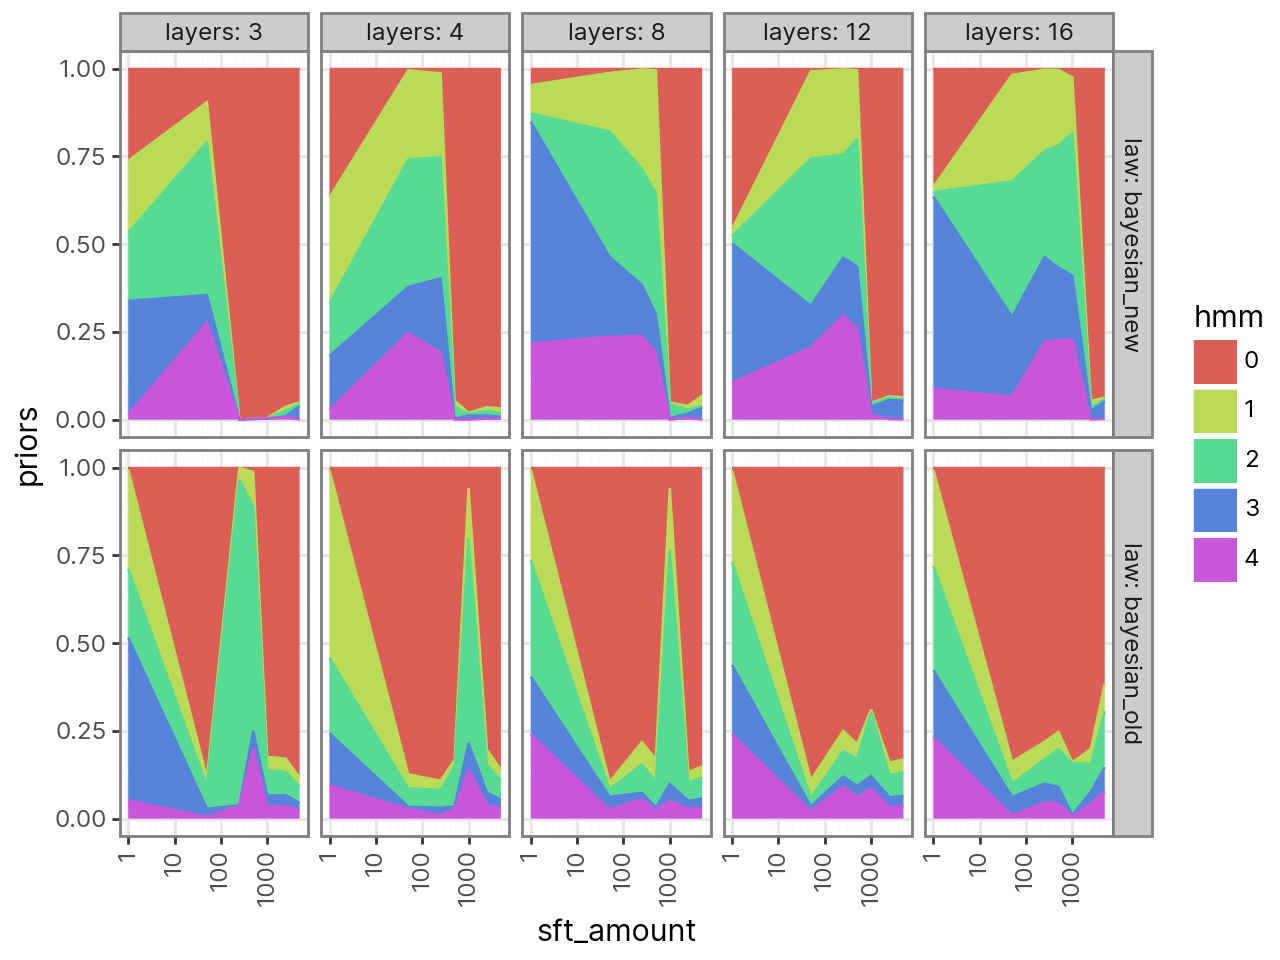

In [81]:
params_sft_df_temp = params_sft_df[(params_sft_df["k"] == 10)]
plot = (
    ggplot(params_sft_df_temp, aes(x="sft_amount", y="priors", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="area", position="stack") + facet_grid("law~layers", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90), text=element_text(family="Inter")) + scale_x_log10()
)
print(plot)

/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_61882/2461163055.py:8: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


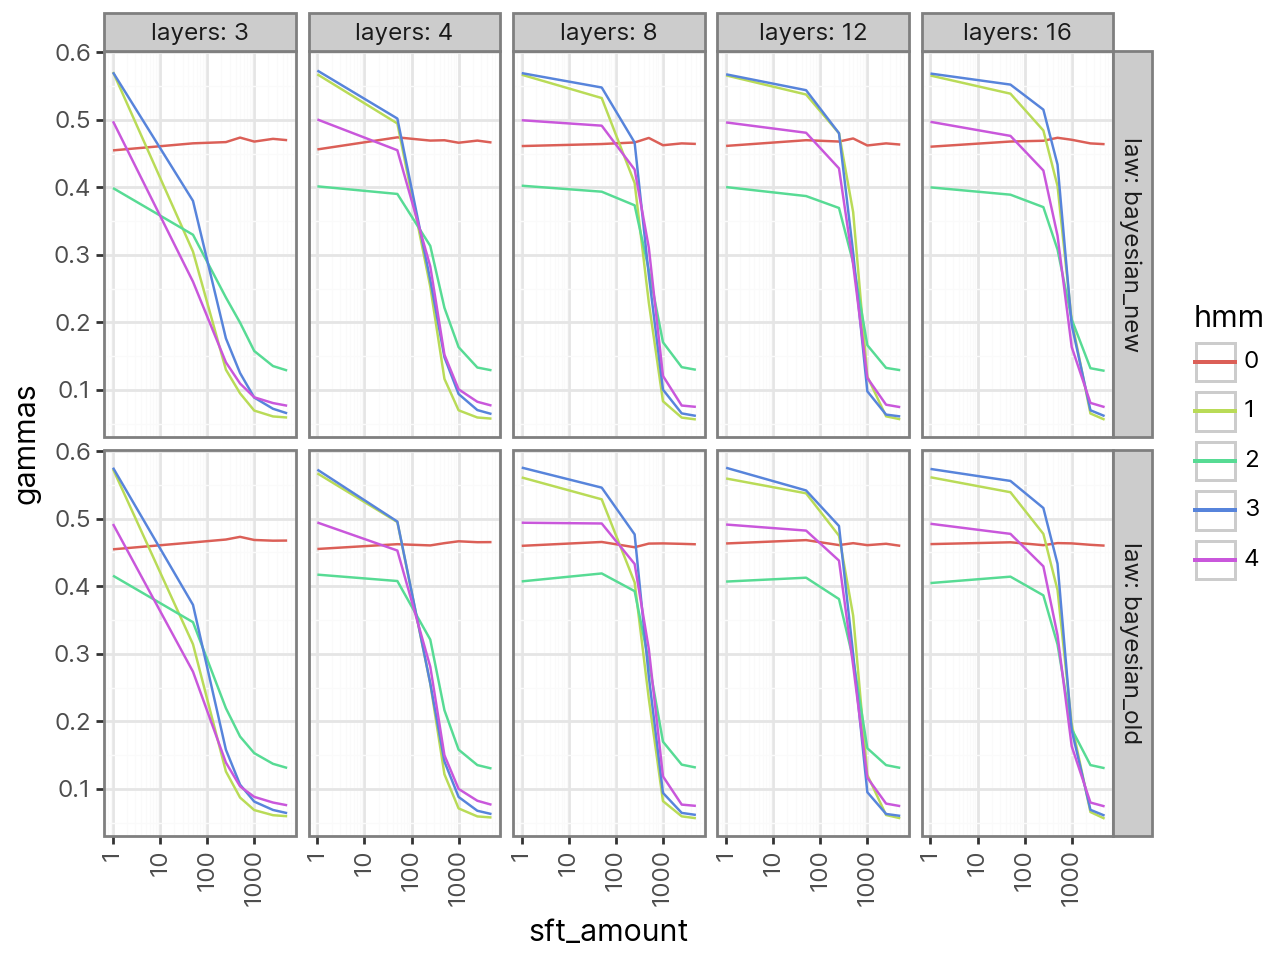

In [82]:
params_sft_df_temp = params_sft_df[(params_sft_df["k"] == 10)]
plot = (
    ggplot(params_sft_df_temp, aes(x="sft_amount", y="gammas", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + facet_grid("law~layers", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90), text=element_text(family="Inter")) + scale_x_log10()
)
print(plot)

/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_61882/3859224037.py:8: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


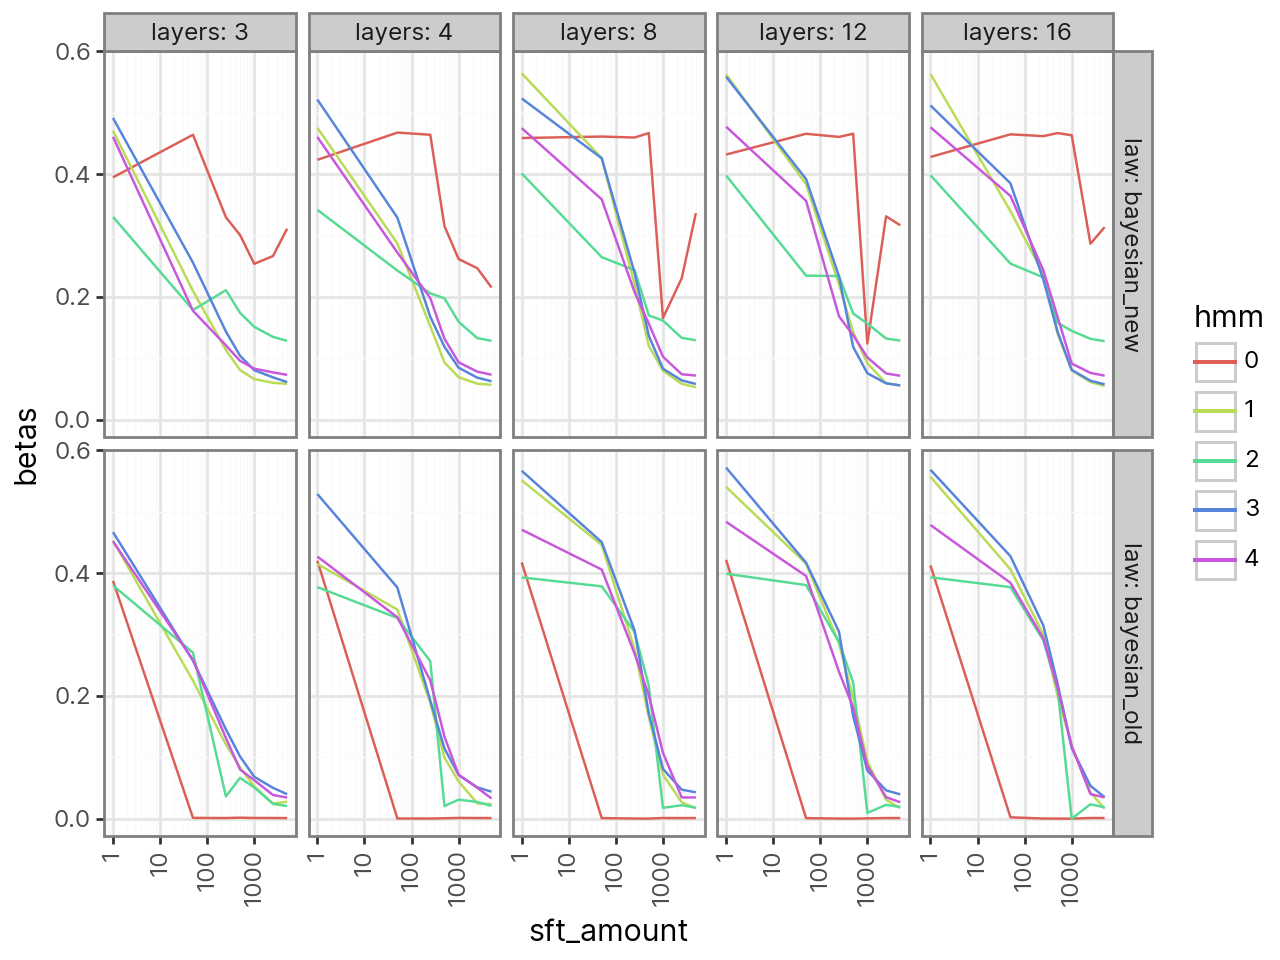

In [83]:
params_sft_df_temp = params_sft_df[(params_sft_df["k"] == 10)]
plot = (
    ggplot(params_sft_df_temp, aes(x="sft_amount", y="betas", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + facet_grid("law~layers", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90), text=element_text(family="Inter")) + scale_x_log10()
)
print(plot)

/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_61882/406715198.py:8: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


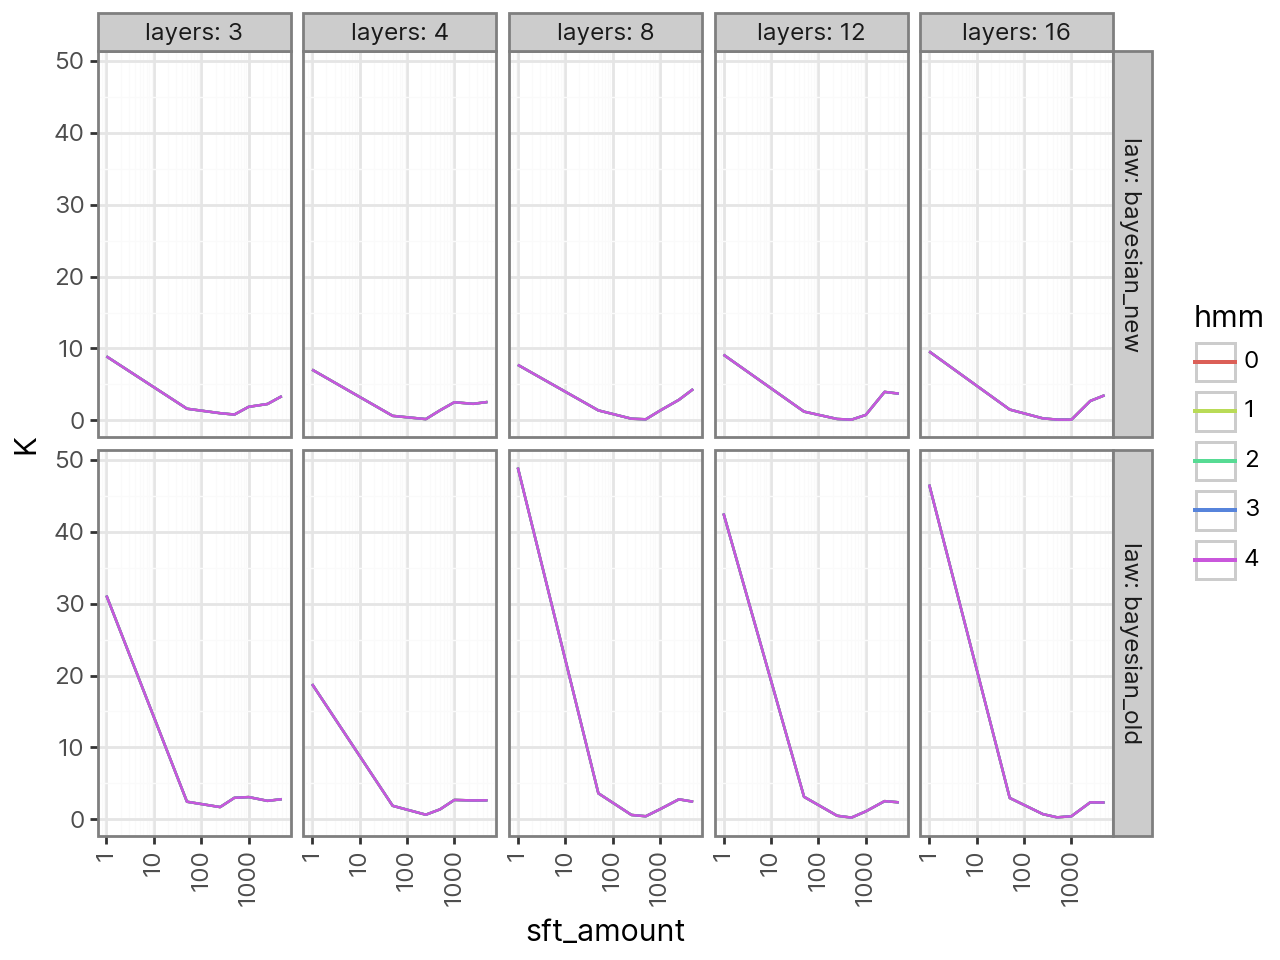

In [84]:
params_sft_df_temp = params_sft_df[(params_sft_df["k"] == 10)]
plot = (
    ggplot(params_sft_df_temp, aes(x="sft_amount", y="K", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + facet_grid("law~layers", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90), text=element_text(family="Inter")) + scale_x_log10()
)
print(plot)

/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_61882/1758393631.py:42: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


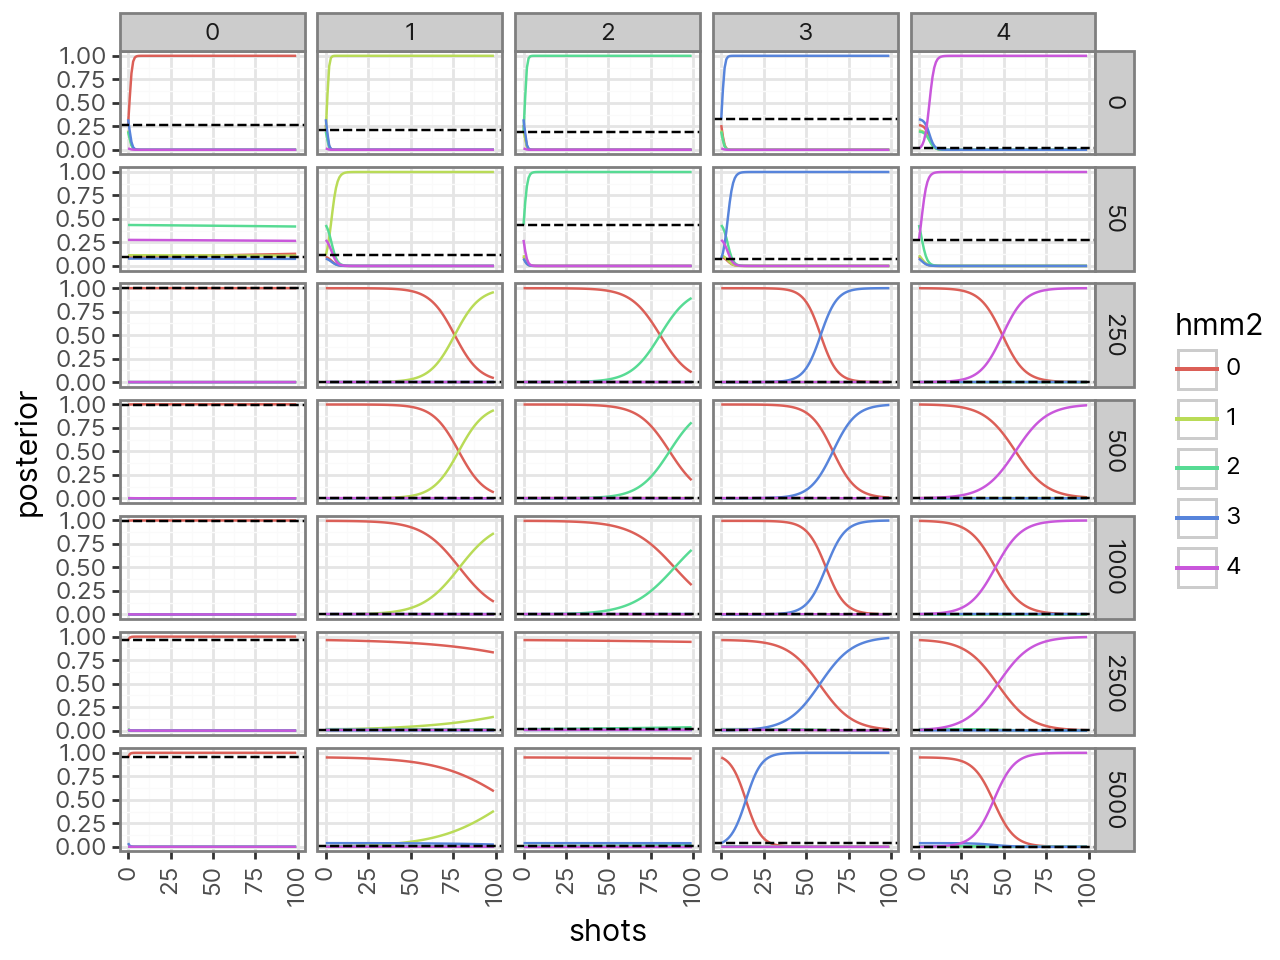

In [90]:
posterior_data = []
prior_data = []
layers = 3
k = 10
for sft_amount in all_models_sft:
    prior = all_models_sft[sft_amount][('new', k, layers)].get_params()["priors"]
    for hmm in range(5):
        est = all_models_sft[sft_amount][('new', k, layers)].estimate_nll(100, hmm, add_metrics=True)
        prior_data.append({
            'hmm': hmm,
            'sft_amount': sft_amount,
            'prior': prior[0][0][hmm]
        })
        posteriors = est['posteriors']
        for hmm2 in range(5):
            posterior_data.append({
                'hmm': hmm,
                'hmm2': hmm2,
                'sft_amount': sft_amount,
                'shots': 0,
                'posterior': prior[0][0][hmm2]
            })
            for shots in range(99):
                posterior_data.append({
                    'hmm': hmm,
                    'hmm2': hmm2,
                    'sft_amount': sft_amount,
                    'shots': shots + 1,
                    'posterior': posteriors[shots, hmm2].item()
                })
    
posterior_df = pd.DataFrame(posterior_data)
posterior_df['hmm'] = posterior_df['hmm'].astype(str)
posterior_df['hmm2'] = posterior_df['hmm2'].astype(str)
prior_df = pd.DataFrame(prior_data)
prior_df['hmm'] = prior_df['hmm'].astype(str)
plot = (
    ggplot(posterior_df, aes(x="shots", y="posterior", group="hmm2", color="hmm2", fill="hmm2")) + facet_grid("sft_amount~hmm") +
    geom_line() + theme_bw() + theme(axis_text_x=element_text(rotation=90), text=element_text(family="Inter")) +
    geom_hline(prior_df, aes(yintercept="prior"), linetype="dashed")
)
print(plot)